# Importing libraries

In [1]:
import cv2
import io
import jupyter_bbox_widget as jbw
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import requests

# Loading image

In [2]:
original_img = cv2.imread('image.jpg')
gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

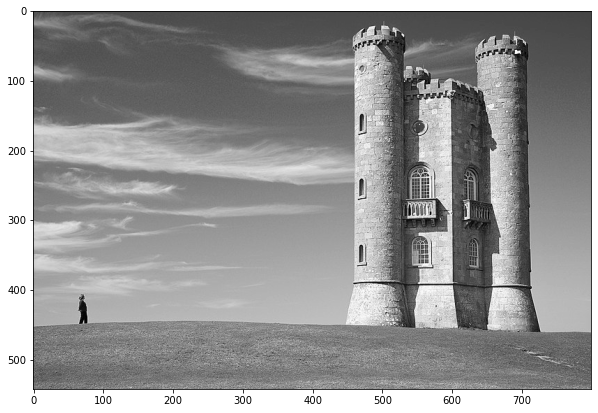

In [3]:
plt.figure(figsize=(10, 8))
plt.imshow(gray_img, cmap='gray')
plt.show()

# Carving

## Finding energy map

In [4]:
def get_energy(gray_img):
    # Kernel for computing gradient w.r.t x
    kx = np.array(
      [[-0.5, 0., 0.5],
       [-1.,  0., 1.],
       [-0.5, 0., 0.5]]
    )

    # Kernel for computing gradient w.r.t y
    ky = np.array(
      [[-0.5, -1., -0.5],
       [0.,   0., 0.],
       [0.5,  1., 0.5]]
    )

    dx = cv2.filter2D(gray_img, -1, kx)
    dy = cv2.filter2D(gray_img, -1, ky)

    energy = dx**2 + dy**2
    return energy.astype(np.float64)

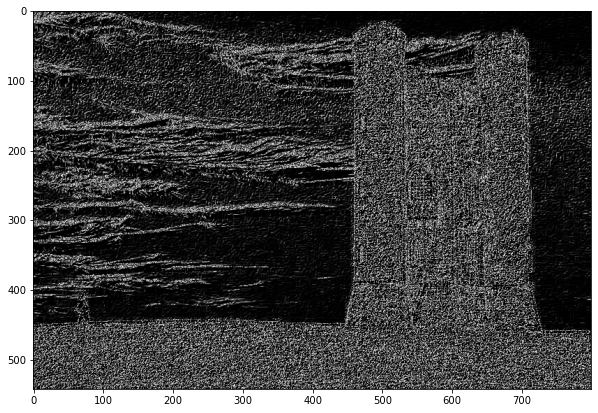

In [5]:
energy = get_energy(gray_img)
plt.figure(figsize=(10, 8))
plt.imshow(energy, cmap='gray')
plt.show()

## Finding min seam

In [6]:
def get_seam(energy, result_type='mask'):
    """Search for minimum total energy seam from `energy` using dynamic
    programming.

    Returns a tuple (min_downward_energy, path), where:
    * min_downward_energy[i, j]: the minumum total energy starting from pixel
    [i, j] down to bottom
    * path[i, j]: the column of the next pixel of [i, j] in the seam, i.e. the
    next pixel for [i, j] is [i+1, path[i, j]]
    """

    num_rows, num_cols = energy.shape

    min_downward_energy = np.zeros_like(energy, dtype=np.int64)
    path = np.zeros_like(energy, dtype=np.int64)

    # Initializing
    min_downward_energy[-1, :] = energy[-1, :].copy()
    base_idx = np.arange(-1, num_cols-1)

    for i in reversed(range(num_rows-1)):
        # These arrays store the values that are below left, below middle, or
        # below right to the values in the ith row
        lefts = np.hstack([np.inf, min_downward_energy[i+1, :-1]])
        middles = min_downward_energy[i+1]
        rights = np.hstack([min_downward_energy[i+1, 1:], np.inf])

        # The indices of the minimum elements among the below left, middle and right
        # of each element in the ith row
        min_idx = np.argmin([lefts, middles, rights], axis=0) + base_idx

        # Updates
        min_downward_energy[i] = energy[i] + min_downward_energy[i+1, min_idx]
        path[i] = min_idx

    # Extracting minimum seam from path
    seam = []
    j = np.argmin(min_downward_energy[0, :])
    i = 0
    while i < num_rows:
        seam.append(j)
        j = path[i, j]
        i += 1

    if result_type == 'mask':
        res = np.zeros_like(energy, dtype=bool)
        res[np.arange(num_rows), seam] = 1
        seam = res
    else:
        seam = np.array(seam)

    return seam

### Utilities

In [7]:
def add_seam_to_image(img, seam_mask):
    """Return a new image with all pixels in the seam stored in `seam_mask` turned
    into magenta.
    """
    with_seam = img.copy()
    # Convert grayscale image to RGB space
    if len(img.shape) == 2:
        with_seam = np.stack([with_seam] * 3, axis=2)

    magenta = np.stack([seam_mask * 255, seam_mask * 0, seam_mask * 255], axis=2)
    with_seam = with_seam * (1 - seam_mask[..., np.newaxis]) + magenta
    return with_seam.astype(np.uint8)

In [8]:
def bgr_rgb(img):
    """Switch back and forth between BGR-formatted and RGB-formatted image
    """
    res = np.empty_like(img)
    res[:, :, 0] = img[:, :, 2].copy()
    res[:, :, 1] = img[:, :, 1].copy()
    res[:, :, 2] = img[:, :, 0].copy()
    return res

### Testing

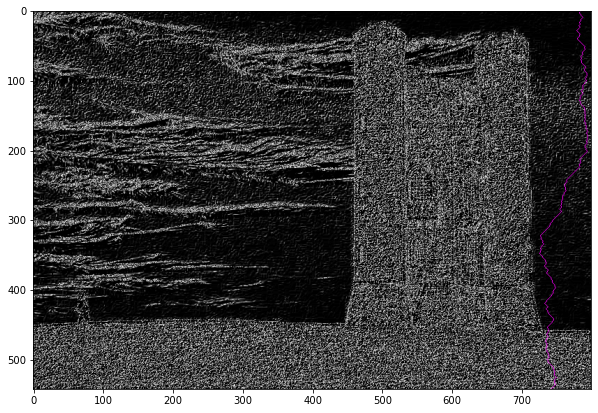

In [9]:
# Find minimum seam
mask = get_seam(energy, result_type='mask')

# Add the seam to the image
with_seam = add_seam_to_image(energy, mask)

# Visualize
plt.figure(figsize=(10, 8))
plt.imshow(with_seam)
plt.show()

## Removing one seam from the image

In [10]:
def carve(img, mask):
    """Remove the seam from image
    """
    
    shape = list(img.shape)

    # Reduce one pixel in column
    shape[1] -= 1

    new_img = np.empty(shape, dtype=img.dtype)
    num_rows = shape[0]
    dim = len(shape)

    # 2D (or grayscale) image
    if dim == 2:
        for i in range(num_rows):
            new_img[i, :] = img[i, :][~mask[i, :]]
    # 3D image
    else:
        for i in range(num_rows):
            new_img[i, :, :] = img[i, :, :][~mask[i, :]]

    return new_img

## Resizing - removing multiple seams

In [11]:
def add_padding_left(img, pad_width):
    """Add a column of white padding to the left of the image
    """
    white_padding = np.full(
        shape=(img.shape[0], pad_width, img.shape[2]),
        fill_value=255,
        dtype=with_seam.dtype
    )
    new_img = np.hstack([img, white_padding])
    return new_img

In [12]:
def resize(img, num_seams, axis=1, create_gif=False, gif_file_name=None, mask=None):
    """Resize image using seam carving
    
    Parameters:
    -----------
    img : np.array
        Source image to resize
    num_seams : int
        Number of seams to remove
    axis : int
        0 to reduce image height, 1 to reduce image width
    create_gif : bool
        Whether to create an animated GIF file of the resizing process
    gif_file_name : str
        GIF file name
    mask : None or tuple of (np.array, np.array)
        If given, supply a tuple of (include_mask, exclude_mask), where
        include_mask specifies pixels to keep while carving, and
        exclude_mask specifies pixels to removed while carving
    
    Returns
    -------
    np.array
        A resized image with the same shape as `img`
    """
    im = img.copy()
    
    # This is if we're reducing the height of the image
    if axis == 0:
        im = cv2.rotate(im, cv2.cv2.ROTATE_90_CLOCKWISE)

    # Maintain a separate grayscale image to compute energy and find seam
    dim = len(img.shape)
    if dim == 3:
        gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Otherwise, the source image is already in grayscale and will be directly
    # used to find energy and seam
    else:
        gray_im = im
        
    # Shape of the image before resizing
    original_shape = im.shape
    # This stores the frames of the GIF file
    gif_frames = []
    
    if mask != None:
        include_mask, exclude_mask = mask
    else:
        include_mask = exclude_mask = np.zeros(gray_im.shape, dtype=bool)
    
    for i in range(num_seams):
        energy = get_energy(gray_im)
        
        # Make the exclude_mask low weighted, and make include_mask
        # high weighted
        temp = energy.copy().astype(np.float64)
        temp = temp * ~exclude_mask + -10e10 * exclude_mask
        temp = temp * ~include_mask + 10e10 * include_mask
        seam = get_seam(temp)

        if create_gif:
            with_seam = add_seam_to_image(im, seam)
            
            # Add a white padding to the right of each resized frame
            with_seam = add_padding_left(with_seam,
                                         pad_width=original_shape[1] - with_seam.shape[1])
            
            # Encode each frame
            is_success, buffer = cv2.imencode('.jpg', with_seam, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
            buffer = io.BytesIO(buffer)
            
            # Open each frame as a PIL.Image and store it
            gif_frames.append(Image.open(buffer))

        # Remove one seam from the image and mask
        im = carve(im, seam)
        include_mask = carve(include_mask, seam)
        exclude_mask = carve(exclude_mask, seam)
        
        # Only carve gray_im if it's a separate image from im
        if dim == 3:
            gray_im = carve(gray_im, seam)

    if create_gif:
        # Export as a GIF file
        frame = gif_frames[0]
        frame.save(fp=gif_file_name, format='GIF', append_images=gif_frames, save_all=True, duration=200, loop=0)

    return im if axis == 1 else cv2.rotate(im, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)

### Reducing width

In [13]:
%%time
reduced_width = resize(original_img, num_seams=50, axis=1, create_gif=True, gif_file_name='reducing-width.gif')
original_img.shape, reduced_width.shape

CPU times: user 6.55 s, sys: 418 ms, total: 6.97 s
Wall time: 6.95 s


((542, 800, 3), (542, 750, 3))

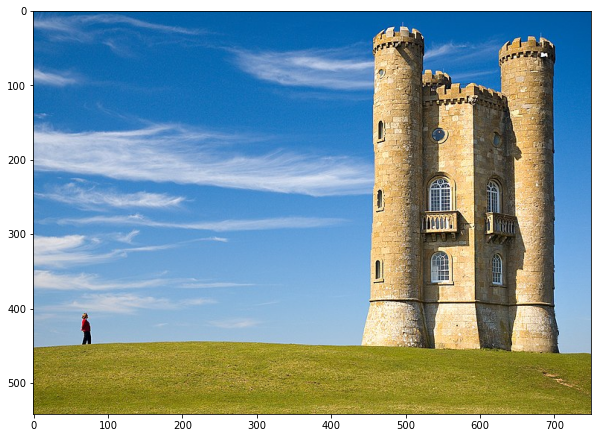

In [14]:
plt.figure(figsize=(10, 8))
plt.imshow(bgr_rgb(reduced_width))
plt.show()

### Reducing height

In [15]:
%%time
reduced_height = resize(original_img, num_seams=50, axis=0, create_gif=True, gif_file_name='reducing-height.gif')
original_img.shape, reduced_height.shape

CPU times: user 7.3 s, sys: 424 ms, total: 7.72 s
Wall time: 7.85 s


((542, 800, 3), (492, 800, 3))

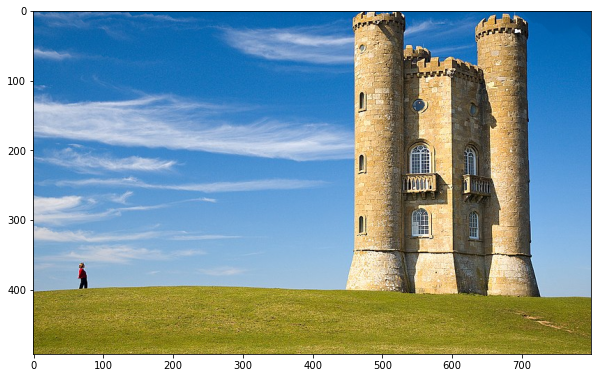

In [16]:
plt.figure(figsize=(10, 8))
plt.imshow(bgr_rgb(reduced_height))
plt.show()

# Creating masks for object

In [17]:
bboxes = [{'x': 60, 'y': 403, 'width': 21, 'height': 50, 'label': 'exclude'},
          {'x': 718, 'y': 29, 'width': 77, 'height': 430, 'label': 'include'}]

In [18]:
# Specifies what pixel to not remove
include_mask = np.zeros(original_img.shape[:2], dtype=bool)
# Specifies what pixel to remove
exclude_mask = np.zeros(original_img.shape[:2], dtype=bool)

for bbox in bboxes:
    x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
    if bbox['label'] == 'include':
        include_mask[y:y+h, x:x+w] = 1
    else:
        exclude_mask[y:y+h, x:x+w] = 1

## Visualizing image with mask

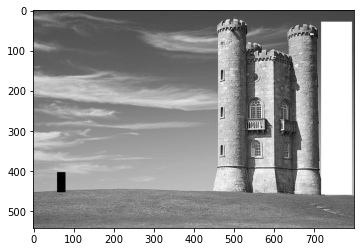

In [19]:
# White for include_mask
with_mask = gray_img * ~include_mask + 255 * include_mask
# Black for exclude_mask
with_mask = with_mask * ~exclude_mask + 0 * exclude_mask
plt.imshow(with_mask, cmap='gray');

## Resizing image with mask

In [20]:
%%time
reduced_width = resize(
    original_img,
    num_seams=100,
    axis=1,
    create_gif=True,
    gif_file_name='reducing-with-mask.gif',
    mask=(include_mask, exclude_mask)
)

CPU times: user 13.2 s, sys: 777 ms, total: 14 s
Wall time: 14.1 s


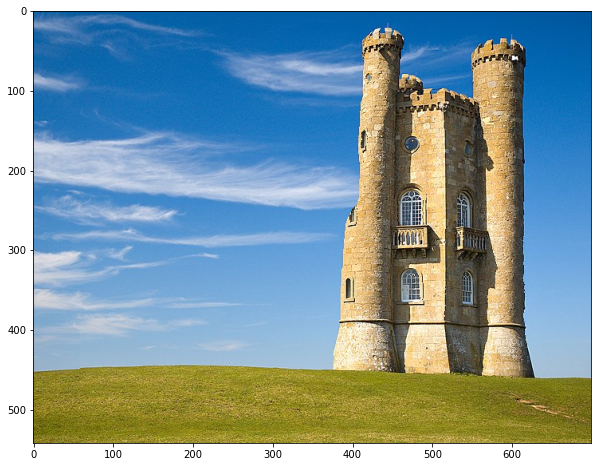

In [21]:
plt.figure(figsize=(10, 8))
plt.imshow(bgr_rgb(reduced_width))
plt.show()

# Enlarging image

To enlarge an image by $k$ seams, first find $k$ seams for removal $s^{(1)}, \dots, s^{(k)}$ (yes, find seams for removal). Then duplicate the seams sequentially, starting from seam $s^{(k)}$ down to seam $s^{(1)}$.

Duplicating a seam $s^{(i)}$ is simply copying $s^{(i)}$ to the right, which pushes the remaining right half of the image (as divided by $s^{(i)}$) one pixel to the right. This means any other seam $s^{(j)}$ $(j \ne i)$ that lies completely, or partially, on the right half of the image needs to be pushed as well. This is because a seam marks the indices of a sequence of pixels that together form the total minimum energy. If we update the image without updating the seam indices, the new pixels no longer sum to minimum energy.

We only pushes the part of a seam $s^{(j)}$ that lies to the right of $s^{(i)}$. To identify which indices to update, we compare the indices of two seams elementwise: $s^{(j)}_k$ is in the right half if $s^{(j)}_k > s^{(i)}_k$. Then update $s^{(j)}_k = s^{(j)}_k + 1$.

In [22]:
seam = get_seam(get_energy(gray_img), result_type='array')

In [86]:
def duplicate_seam(img, seam):
    h, w, d = img.shape
    new_img = np.empty((h, w+1, d), dtype=img.dtype)
    
    for r in range(h):
        new_img[r, :seam[r], :] = img[r, :seam[r], :]
        new_img[r, seam[r], :] = img[r, seam[r], :]
        new_img[r, seam[r] + 1, :] = img[r, seam[r], :]
        new_img[r, seam[r] + 2:, :] = img[r, seam[r] + 1:, :]
    return new_img

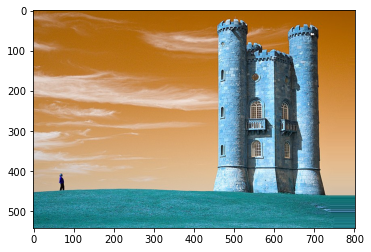

In [24]:
added = duplicate_seam(original_img, seam)
# added.shape
plt.imshow(added)
# plt.imshow(original_img)

In [87]:
def enlarge(img, num_seams):
    # Find k seams for removal
    im = img.copy()
    gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    num_rows, num_cols = gray_img.shape
    seams = []
    for i in range(num_seams):
        seam = get_seam(get_energy(gray_img), result_type='array')
        seams.append(seam)
        
        # Turn seam from array structure to mask
        tmp = np.zeros_like(gray_img, dtype=bool)
        tmp[np.arange(num_rows), seam] = 1
        carve(gray_img, tmp)
    
    while seams:
        seam = seams.pop()
        im = duplicate_seam(im, seam)
        
        # Update indices of other seams
        for other in seams:
            other[other > seam] += 1
    return im

CPU times: user 4.82 s, sys: 6.5 ms, total: 4.83 s
Wall time: 4.82 s


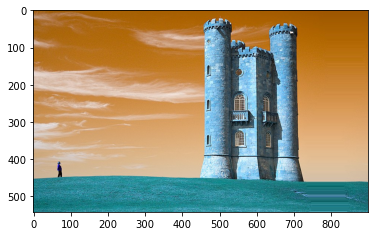

In [88]:
%%time
plt.imshow(enlarge(original_img, 100))

# Remove an object by mask without changing image size

In [80]:
def remove_object(img, mask):
    exclude_mask = mask[1]
    a = exclude_mask.any(axis=0)
    a = np.argwhere(a).ravel()
    
    num_seams = a[-1] - a[0] + 1
    print(num_seams)
    
    # Remove in two stages
    # Stage 1: Remove the object
    tmp = resize(img, num_seams, mask=mask)
    
    # Stage 2: Enlarge the image
    tmp = enlarge(tmp, num_seams)
    
    return tmp

77
CPU times: user 8.5 s, sys: 9.8 ms, total: 8.51 s
Wall time: 8.51 s


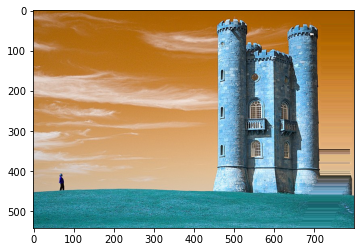

In [89]:
%%time
p = remove_object(original_img, (exclude_mask, include_mask))
plt.imshow(p);